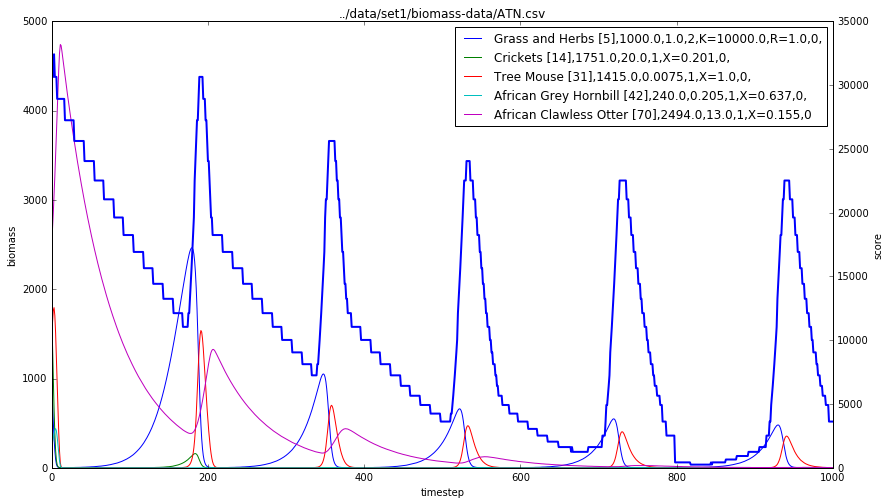

{
    "5": {
        "K": 10000.0,
        "R": 1.0,
        "initialBiomass": 1000.0,
        "name": "Grass and Herbs",
        "nodeId": 5,
        "perUnitBiomass": 1.0,
        "trophicLevel": 1.0
    },
    "14": {
        "X": 0.201,
        "initialBiomass": 1751.0,
        "name": "Crickets",
        "nodeId": 14,
        "perUnitBiomass": 20.0,
        "trophicLevel": 2.125
    },
    "31": {
        "X": 1.0,
        "initialBiomass": 1415.0,
        "name": "Tree Mouse",
        "nodeId": 31,
        "perUnitBiomass": 0.0075,
        "trophicLevel": 2.38095
    },
    "42": {
        "X": 0.637,
        "initialBiomass": 240.0,
        "name": "African Grey Hornbill",
        "nodeId": 42,
        "perUnitBiomass": 0.205,
        "trophicLevel": 2.66657
    },
    "70": {
        "X": 0.155,
        "initialBiomass": 2494.0,
        "name": "African Clawless Otter",
        "nodeId": 70,
        "perUnitBiomass": 13.0,
        "trophicLevel": 3.53891
    }
}


In [1]:
%matplotlib inline

import os

import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display

from create_feature_file import getSimNumber
from plot_atn_csv import plotCsv

csvDir = '../data/set1/biomass-data'
filenames = os.listdir(csvDir)
filenames.sort(key=lambda f: getSimNumber(f))

def plotFile(filename):
    plotCsv(os.path.join(csvDir, filename))

selectWidget = interactive(plotFile, filename=widgets.Select(description="File", options=filenames))
display(selectWidget)
